# Straight vs Bent Rays

In this notebook we compare straight vs bent rays for a synthetic cross-borehole example.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyfm2d
from scipy.stats import multivariate_normal

/Users/eart0665/Documents/Oxford/Work/harmtransc/.venv/lib/python3.12/site-packages/pyfm2d/wavetracker.py:4: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.interpolate import RectBivariateSpline


## Create Synthetic Dataset

The true velocity model is a couple of Gaussians.

In [2]:
def get_gauss_model(
    extent: list[float], nx: int, ny: int
):
    # Velocities
    vc1 = 1700
    vc2 = 2300
    vb = 2000

    # Grid setup
    xc = np.linspace(extent[0], extent[1], nx)
    yc = np.linspace(extent[2], extent[3], ny)
    X, Y = np.meshgrid(xc, yc, indexing="ij")

    # Gaussian centers and spreads
    dex = extent[1] - extent[0]
    dey = extent[3] - extent[2]
    center1_x = extent[0] + (7.0 - extent[0]) * dex / 20.0
    center1_y = extent[0] + (22.0 - extent[0]) * dey / 30.0
    center2_x = extent[0] + (12.0 - extent[0]) * dex / 20.0
    center2_y = extent[0] + (10.0 - extent[0]) * dey / 30.0
    sigma1 = 6.0 * dex / 20.0
    sigma2 = 10.0 * dex / 20.0

    # Multivariate normals
    rv1 = multivariate_normal([center1_x, center1_y], [[sigma1, 0], [0, sigma1]])
    rv2 = multivariate_normal([center2_x, center2_y], [[sigma2, 0], [0, sigma2]])

    # Probability densities
    pos = np.stack((X, Y), axis=-1)
    gauss1 = rv1.pdf(pos)
    gauss2 = rv2.pdf(pos)

    # Model
    model = vb * np.ones([nx, ny])
    model += (vc1 - vb) * gauss1 / np.max(gauss1)
    model += (vc2 - vb) * gauss2 / np.max(gauss2)
    return model


In [ ]:
extent = [0.0, 20.0, 0.0, 30.0]
m = get_gauss_model(extent, 32, 48)
g2 = pyfm2d.BasisModel(m, extent=extent)
velocity = g2.get_velocity()

Create some sources and receivers either side of the borehole.

In [ ]:
recs = pyfm2d.wavetracker.generate_surface_points(
    10, extent=extent, surface=[False, True, False, False], addCorners=False
)
srcs = pyfm2d.wavetracker.generate_surface_points(
    10, extent=extent, surface=[True, False, False, False], addCorners=False
)
nr = len(recs)  # number of receivers
ns = len(srcs)  # number of sources

Calculate the travel times to create the synthetic dataset (and ray paths for visualisation)

In [12]:
options = pyfm2d.WaveTrackerOptions(
    times=True,
    paths=True
)
result = pyfm2d.calc_wavefronts(
    velocity, recs, srcs, nthreads=8, extent=extent, options=options
)

/Users/eart0665/Documents/Oxford/Work/harmtransc/.venv/lib/python3.12/site-packages/pyfm2d/wavetracker.py:4: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.interpolate import RectBivariateSpline
/Users/eart0665/Documents/Oxford/Work/harmtransc/.venv/lib/python3.12/site-packages/pyfm2d/wavetracker.py:4: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.interpolate import RectBivariateSpline
/Users/eart0665/Documents/Oxford/Work/harmtransc/.venv/lib/python3.12/site-packages/pyfm2d/wavetracker.py:4: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.interpolate import RectBivariateSpline
/Users/eart0665/Documents/Oxford/Work/harmtransc/.venv/lib/python3.12/site-packages/pyfm2d/wavetracker.py:4: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this ve

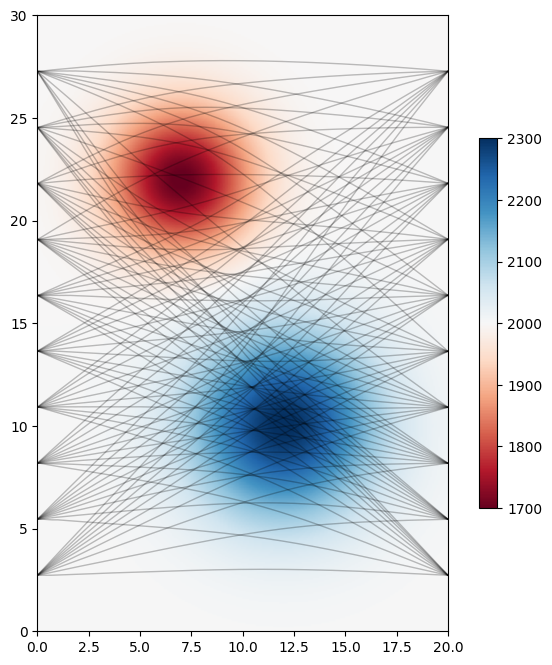

In [ ]:
pyfm2d.display_model(velocity, extent=extent, figsize=(8, 8), clim=(1700, 2300), paths=result.paths, alpha=0.25)

Add some random noise of known covariance.

Text(0, 0.5, 'Travel Time')

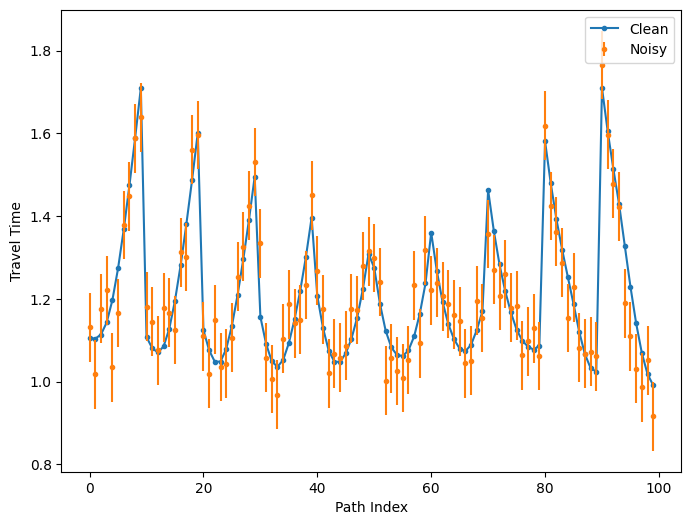

In [29]:
rng = np.random.default_rng(42)
std = 0.5 * np.std(result.ttimes)
d_obs = result.ttimes + rng.normal(0, std, result.ttimes.shape)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(result.ttimes, marker=".", label="Clean")
ax.errorbar(np.arange(len(d_obs)), d_obs, yerr=std, fmt=".", label="Noisy")
ax.legend()
ax.set_xlabel("Path Index")
ax.set_ylabel("Travel Time")